# Рекомендация курсов пользователям образовательной платформы

В данном дипломном проекте построена рекомендательная система для образовательной онлайн платформы **Отус**. Необходимо обучить модель, которая для каждого пользователя (имя пользователя закодировано через `user_id`) будет рекомендовать ему 3 курса (`course_id`) из тех, которые он еще не слушал. При этом модель должна уметь работать как со старыми пользователями, так и с новыми, которые еще не приобрели ни одного курса.

## Данные
Для построения модели доступны данные о взятых пользователями курсе(-ах).

### Данные

**otus_user_course.csv** - таблица пользователь-курс с информацией о взятых пользователями курсах 

- user_id - уникальный идентификатор пользователя
- course_id (item_id) - уникальный идентификатор курса

**course_info.csv** - информация обо всех курсах

- id (references otus_user_course (course_id)) - уникальный идентификатор курса
- title - название курса

# Рекомендательная система
 

Монтируем диск в google colab.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Устанавливаем библиотеку surprise.

In [ ]:
!pip install surprise

Загружаем необходимые библиотеки.

In [3]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline
from surprise import SVD
from surprise.model_selection import cross_validate
from surprise import Reader
from surprise import Dataset

## и другие по мере необходимости

**Загружаем данные.**

Пользователь - курс.

In [4]:
otus_user_course = pd.read_csv('/content/drive/My Drive/Colab Notebooks/otus/diplom/data/otus_user_course.csv', index_col = 0)

Курс - название.

In [5]:
course_info = pd.read_csv('/content/drive/My Drive/Colab Notebooks/otus/diplom/data/course_info.csv', index_col = 0)

Проведём предварительный анализ данных в разрезе рекомендательных систем.

In [6]:
otus_user_course.shape

(14975, 2)

Проверим есть ли дубликаты в таблице. Нам такие данные не нужны, это ошибка, поскольку пользователь может брать определённый курс только однажды, повторное обучение недопустимо.

In [7]:
otus_user_course[otus_user_course.duplicated(keep=False)].groupby('user_id').count().sort_values('course_id', ascending=False)

,course_id
user_id,
21160,8
2860,6
20774,6
120862,6
60657,6
...,...
18709,2
18902,2
18966,2


Удалим дубликаты, посмотрим сколько останется данных.

In [8]:
otus_user_course = otus_user_course.drop_duplicates()

In [9]:
otus_user_course.shape

(14675, 2)

Действительно, дубликаты были в данных.

In [10]:
otus_user_course.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14675 entries, 0 to 14974
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   user_id    14675 non-null  int64
 1   course_id  14675 non-null  int64
dtypes: int64(2)
memory usage: 343.9 KB


In [11]:
otus_user_course.head(5)

,user_id,course_id
0,4,1
1,81,1
2,83,1
3,120,1
4,123,1


Таблица **course_info**

In [12]:
course_info.shape

(240, 2)

Проверка на дубликаты.

In [13]:
course_info[course_info.duplicated(keep=False)]

,id,title


Дубликатов нет.

In [14]:
course_info = course_info.drop_duplicates()

In [15]:
course_info.shape

(240, 2)

In [16]:
course_info.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 240 entries, 0 to 239
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      240 non-null    int64 
 1   title   240 non-null    object
dtypes: int64(1), object(1)
memory usage: 5.6+ KB


In [17]:
course_info.sample(5)

,id,title
123,132,Специализация php-разработчик
227,242,C# Базовый курс
183,193,Принятие инвестиционных решений в ИТ
195,206,Data Engineer для Райффайзенбанка
208,222,Подготовка к проведению открытых мероприятий


Среди названий курсов есть курс, который требует его **Удалить**.

In [18]:
course_info[course_info['id']==96]

,id,title
87,96,Удалить


Перед тем, как удалить эту строчку из таблицы **course_info** посмотрим, **не выбрал ли** кто из пользователей этот 'курс'.

In [19]:
otus_user_course[otus_user_course['course_id']==96]

,user_id,course_id


Хорошо, что курс, помеченный как 'Удалить' никто не брал из пользователей. Следовательно, можно спокойно удалить одну строчку ТОЛЬКО из одной таблицы **course_info**.

In [20]:
course_info = course_info.query("id!=96")

In [21]:
course_info.shape

(239, 2)

Предварительно мы подготовили таблицы к дальнейшим действиям.

**Важно узнать, кто взял курсы, а кому надо посоветовать взять курсы.**

Посмотрим, сколько уникальных пользователей взяли курсы. Можно посмотреть какие курсы, какие пользователи брали, сгруппировав по уникальным пользователям и отсортировав по взятым курсам.

Вычислим количество уникальных пользователей. И общее количество пользователей.

In [22]:
len(otus_user_course.user_id.unique()), len(otus_user_course.user_id)

(5830, 14675)

Результат следующего кода очень интересен. Возможно его стоит повторить дальше, когда буду рассматривать вариант рекомендаций. Фактически здесь отражена популярность, возможно аномальная у некоторых пользователей, интересно, с чем это связано.

In [23]:
otus_user_course.groupby('user_id').count().sort_values('course_id', ascending=False)

,course_id
user_id,
17896,52
14064,49
13708,42
7673,25
2785,23
...,...
65872,1
65887,1
65903,1


Видно, что некоторые пользователи брали очень много курсов, кто-то взял 52 курса, убедимся в этом.

In [24]:
len(otus_user_course.loc[otus_user_course['user_id']==17896])

52

# Baseline

В качестве baseline мы предлагаем MostPopular алгоритм, который рекомендует пользователю самые популярные курсы из тех, что он еще не брал. Для данного алгоритма нам понадобится всего две колонки `user_id`,`course_id` из таблицы `user_course`.

In [25]:
X = otus_user_course.copy() #.drop_duplicates() уже удалили дубликаты
X.head()

,user_id,course_id
0,4,1
1,81,1
2,83,1
3,120,1
4,123,1


Для отладки алгоритма разобьем данные на train и test. В baseline решении используется самая простая разбивка (на то это и baseline), возможно, вы захотите сделать что-то более умное, например, учитывающие id юзера.

In [26]:
from sklearn.model_selection import train_test_split

X_train, y_val = train_test_split(X, random_state= 1, test_size = 0.3)
print(X_train.shape, y_val.shape)
val_idx = list(sorted(set(y_val.user_id)))

(10272, 2) (4403, 2)


### Most Popular Algorithm
На этапе обучения вычисляет наиболее популярные курсы в обучающих данных, на этапе предсказания - выбирает top popular, из тех которые пользователь еще не брал.

In [27]:
from sklearn.base import BaseEstimator
class MostPopular(BaseEstimator):
    def fit(self, train):
        self.most_popular = list(train.course_id.value_counts().index)
        self.users_items = train[['user_id', 'course_id']]
        return self
    
    def predict_items(self, user_id, n = 3):
        taken_courses = set(self.users_items[self.users_items.user_id == user_id].course_id)
        return [x for x in self.most_popular if not x in taken_courses][:n]
        
    
    def predict(self, user_ids, n = 3):
        y = [self.predict_items(user_id, n = n) for user_id in user_ids]
        return y

In [28]:
# Обучаем модель
estimator = MostPopular().fit(X_train)

# Метрика 
В качестве метрики качества в соревновании используется **MeanAveragePrecision@3**:

$$ AveragePrecision@3(user) = \frac{1}{3}\sum_{i = 1}^3y_i \cdot presicion@i(user)$$

$y_i \in {0,1}$ - бинарная метка $i$-го предсказания (верно предсказал/неверно);

$presicion@i(user)$ - доля верно предсказанных среди первый $i$ курсов. 

Итоговая метрика считается усреднением по всем юзерам:

$$MeanAveragePrecision@3 = \frac{1}{|U|}\sum_{user \in U} AveragePrecision@3(user) $$

Подробное описание метрики можно прочитать тут: https://habr.com/ru/company/econtenta/blog/303458/

При оценке используется решения используется реализация метрики из библиотеки `ml_metrics`: https://github.com/benhamner/Metrics/blob/master/Python/ml_metrics/average_precision.py

In [ ]:
!pip install ml_metrics

In [30]:
from ml_metrics import mapk

In [31]:
val_preds = estimator.predict(val_idx)
y_val_true = [list(set(y_val[y_val.user_id == idx].course_id)) for idx in val_idx]
val_preds[:3], y_val_true[:3]

([[7, 1, 15], [7, 15, 3], [7, 15, 34]], [[1], [51], [51]])

Посмотрим на названия рекомендаций. Для этого загрузим информацию о курсах из файла course_info.csv.

In [32]:
course_info.head()

,id,title
0,1,Java Developer. Professional
1,2,Разработчик Android (deprecated)
2,3,Python Developer. Professional
3,4,Разработчик Ruby
4,5,C++ Developer. Professional


In [33]:
id2course = {}
for i, row in course_info.iterrows():
    id2course[i] = row.title
    
print([id2course[i] for i in val_preds[0]])

['Backend-разработчик на PHP', 'Разработчик Android (deprecated)', 'Разработчик Java\xa0(очно в МАИ)']


In [34]:
# Вычислим MAP@3
print('MAP@3 = ', round(mapk(
    y_val_true, 
    val_preds, 
    k=3
),3))

MAP@3 =  0.109


***Примечание:***  
Если сделать разбивку с другим random_state, например random_state = 42, то MAP@3 увеличится незначительно, до 0.113

# Методы рекомендаций.

Здесь нужно добавить разных библиотек, в том числе графического толка.

In [ ]:
!pip install seaborn

In [36]:
import seaborn as sbs

Нужно перевести номер id во временную метку. Если id очень маленький, значит этот курс брали очень давно. Имеют ли id пользователи пропуски?

In [37]:
otus_user_course.user_id

0             4
1            81
2            83
3           120
4           123
          ...  
14970    117282
14971    186547
14972    186835
14973    128483
14974    187639
Name: user_id, Length: 14675, dtype: int64

Видно, что можно поиграться с временным рядом и сделать рекомендации по временному аспекту и популярности курсов в тот или иной момент времени. Интересно, в какой промежуток времени были популярны определённые курсы. Следовательно у нас появится метка user_id, и можно задавая метку, то есть задаваясь значением user_id, предсказывать какой курс этому пользователю будет интересней взять. Может даже стоит кластеризовать сгустки по user_id. Возможно мы сможем предсказать когда будет следующий наплыв пользователей и какие курсы они пожелают взять.

Нарисуем гистограмму распределения популярности курсов, исходя из user_id.
По идее приближение этой кривой является аналогом популярности курсов со временем.

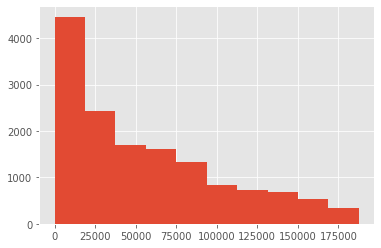

In [38]:
otus_user_course.user_id.hist()

Тот же график, изображённый с помощью seaborn.

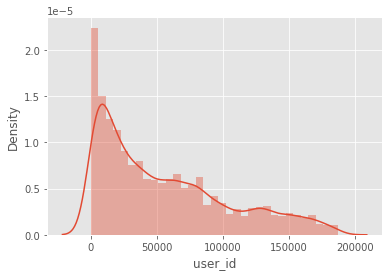

In [39]:
sns_plot = sns.distplot(otus_user_course.user_id)
fig = sns_plot.get_figure()

И только его форма.

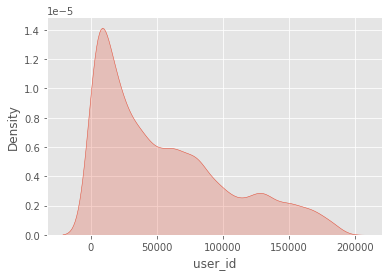

In [40]:
snsplot = sns.kdeplot(otus_user_course.user_id, shade=True)
fig = snsplot.get_figure()

С помощью этого графика, можно заметить, что интерес к курсам угасает со временем. И имеет смысл разбить данные по условно-временному признаку в соотношении 70/30. Отличие текущей идеи разделения будет не по популярности курсов конкретных, а по общей заинтересованности брать любые курсы. Тем самым будет больше информативность данных, из которых будет и состоять рекомендация.

In [41]:
otus_user_course.user_id.min(), otus_user_course.user_id.max()

(4, 187639)

Сначала разобьём гисторграмму популярности по user_id, посмотрим соотношение популярностей в каждом из двух полученных частей.

In [42]:
df_rbound = (otus_user_course.user_id.max() - otus_user_course.user_id.min())*0.7 + otus_user_course.user_id.min()

In [43]:
df_rbound

131348.5

In [44]:
len(otus_user_course.user_id[otus_user_course.user_id<df_rbound]), len(otus_user_course.user_id) 

(13113, 14675)

Посмотрим соотношение.

In [45]:
len(otus_user_course.user_id[otus_user_course.user_id<df_rbound])/len(otus_user_course.user_id) 

0.8935604770017036

Нужно сдвигать, границу, чтобы разделение было 70/30 на train/test.

In [46]:
timebound_coeff = 0.4057

df_rbound = (otus_user_course.user_id.max() - otus_user_course.user_id.min())*timebound_coeff + otus_user_course.user_id.min()


train_test_ratio = len(otus_user_course.user_id[otus_user_course.user_id<df_rbound])/len(otus_user_course.user_id)
df_rbound, train_test_ratio

(76127.5195, 0.6998296422487224)

Мы знаем наш otus_user_course, как переменную X. 

In [47]:
X

,user_id,course_id
0,4,1
1,81,1
2,83,1
3,120,1
4,123,1
...,...,...
14970,117282,252
14971,186547,238
14972,186835,238
14973,128483,23


Акцентрируем, что в следующем коде мы провели не случайный сплит, а сплит по интересам.

In [48]:
#from sklearn.model_selection import train_test_split

#X_train, y_val = train_test_split(X, random_state= 1, test_size = 0.3)
#print(X_train.shape, y_val.shape)
#val_idx = list(sorted(set(y_val.user_id)))

X_train, y_val = X[X.user_id<df_rbound], X[X.user_id>=df_rbound]
print(X_train.shape, y_val.shape)
val_idx = list(sorted(set(y_val.user_id)))

(10270, 2) (4405, 2)


До этого было приблизительно такое же распределение. 10272 и 4403 по трейн-тесту, если сравнивать.

**Разделение датасета по user_id с учётом популярности курсов со 'временем'.**

In [49]:
val_preds = estimator.predict(val_idx)
y_val_true = [list(set(y_val[y_val.user_id == idx].course_id)) for idx in val_idx]
val_preds[:3], y_val_true[:3]

([[7, 15, 3], [7, 1, 15], [7, 1, 15]],
 [[1, 34, 194, 73, 137, 43, 171, 110, 20, 116], [108], [108]])

In [ ]:
course_info.head()

,id,title
0,1,Java Developer. Professional
1,2,Разработчик Android (deprecated)
2,3,Python Developer. Professional
3,4,Разработчик Ruby
4,5,C++ Developer. Professional


In [ ]:
id2course = {}
for i, row in course_info.iterrows():
    id2course[i] = row.title
    
print([id2course[i] for i in val_preds[0]])

['Backend-разработчик на PHP', 'Разработчик Java\xa0(очно в МАИ)', 'Разработчик Ruby']


In [ ]:
# Вычислим MAP@3
print('MAP@3 = ', round(mapk(
    y_val_true, 
    val_preds, 
    k=3
),3))

MAP@3 =  0.02


Раньше мы выполнинили следующий код, интересно, где располагаются самые активные участники по временной шкале?

In [ ]:
ouc_cpu = otus_user_course.groupby('user_id').count().sort_values('course_id', ascending=False)
ouc_cpu # courses per user Количество курсов, который брал тот или иной пользователь 

,course_id
user_id,
17896,52
14064,49
13708,42
7673,25
2785,23
...,...
65872,1
65887,1
65903,1


Нарисуем график, на котором отобразим количество пользователей, которые брали определённое количество курсов.

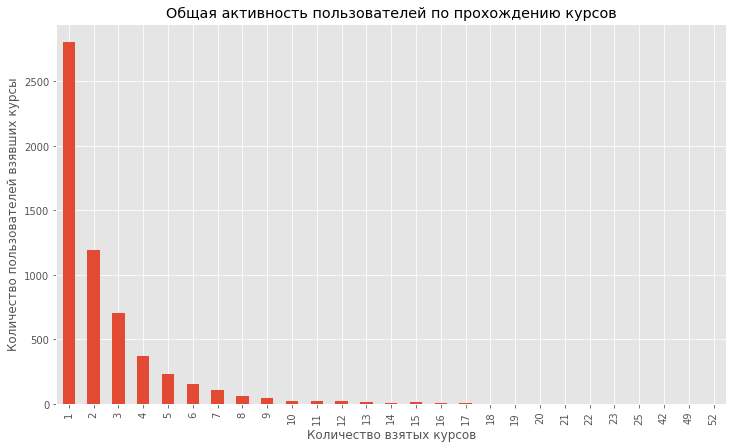

In [ ]:
ouc_cpu['course_id'].value_counts().sort_index().plot.bar(figsize=(12,7))
plt.title('Общая активность пользователей по прохождению курсов')
plt.xlabel('Количество взятых курсов')
plt.ylabel('Количество пользователей взявших курсы')
plt.show()
## Красиво будет обозначить количество элементов над столбцом,
## можно использовать plotly

In [ ]:
st = otus_user_course.groupby('user_id').count().sort_values('course_id', ascending=False)>=3
st
st.course_id.value_counts()

False    4000
True     1830
Name: course_id, dtype: int64

Обратная задача: Какое количество людей прошло данный курс.

In [ ]:
ouc_upc = otus_user_course.groupby('course_id').count().sort_values('user_id', ascending=False)
ouc_upc # users per course Количество пользователей, который брали тот или иной курс 

,user_id
course_id,
7,733
1,727
15,694
3,454
34,445
...,...
248,1
206,1
120,1


Здесь явно три фаворита, с которыми не прогадаешь, но вдруг наши старые или новые пользователи не удосужаться полюбить эти курсы?  
Есть ли вообще непопулярные курсы, которые ни разу не брали, и ли их брать тогда? У нас получилось 173 курса, которые так или иначе берут, хотя бы по одному разу, но ведь всего 239 курсов (один мы уже намеренно удалили). Так какие курсы  у нас не пользуются популярностью?

In [ ]:
courses_notzero = ouc_upc.reset_index().course_id.tolist() # список курсов по популярности
courses_allmost = course_info.id.tolist() # список всех курсов, кроме явно, которое следовало удалить

Вычтем из одного листа другой и мы найдём совсем не интересные курсы.

In [ ]:
## courses_allmost - courses_notzero ???
courses_zero = []
for i in courses_allmost:
    if not (i in courses_notzero):
        courses_zero.append(i)
len(courses_zero)

66

Выведем список нежеланных курсов, их название.

In [ ]:
#id2course = {}
#for i, row in course_info.iterrows():
#    id2course[i] = row.title
    
#print([id2course[i] for i in val_preds[0]])

course_info.loc[course_info.id.isin(courses_zero)]

,id,title
1,2,Разработчик Android (deprecated)
3,4,Разработчик Ruby
10,11,Курс для преподавателей
36,42,Software developer in test
38,44,ML-СКБ
...,...,...
234,249,Базовый Linux для Почта России
235,251,Machine Learning. Basic
237,253,AWS for Data Science
238,254,Системный аналитик. Basic


In [ ]:
otus_user_course.loc[otus_user_course.course_id.isin([2, 4, 11])] # То есть действительно эти курсы никто раньше не брал, 
# в бейзлайне мы их использовали, а если их почистить или убрать полностью?

,user_id,course_id


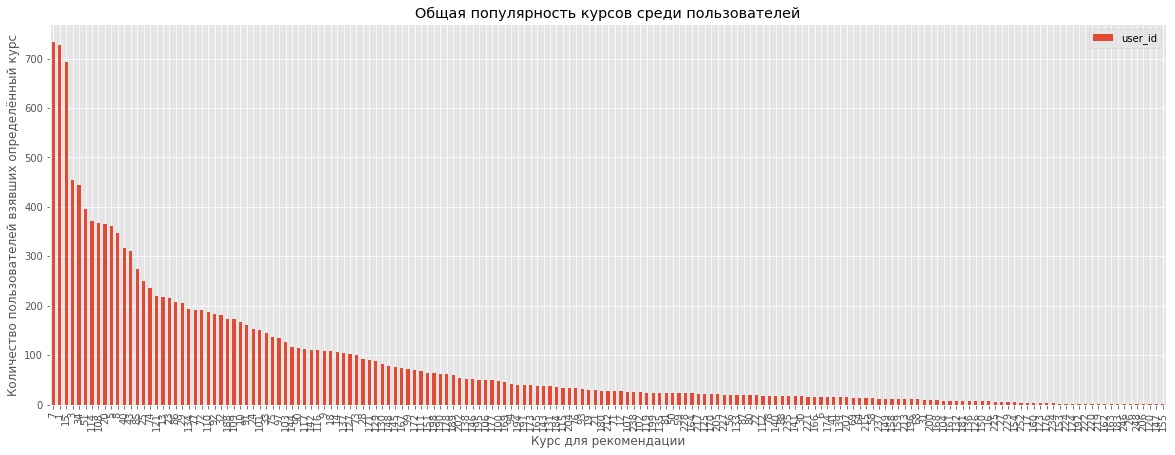

In [ ]:
#ouc_upc['user_id'].value_counts().sort_index().plot.bar(figsize=(20,7))
ouc_upc.plot.bar(figsize=(20,7))
plt.title('Общая популярность курсов среди пользователей')
plt.xlabel('Курс для рекомендации')
plt.ylabel('Количество пользователей взявших определённый курс')
plt.show()
## Красиво будет обозначить количество элементов над столбцом,
## можно использовать plotly

Возможно надо поиграть с уникальными значениями в курсах.

In [ ]:
course_info.loc[course_info['id'].isin([7,1,15])]

,id,title
0,1,Java Developer. Professional
6,7,DevOps практики и инструменты
14,15,Administrator Linux. Professional


In [ ]:
st = otus_user_course.groupby('user_id').count().sort_values('course_id', ascending=False)>=3
st
st.course_id.value_counts()

False    4000
True     1830
Name: course_id, dtype: int64

Попробуем сделать классическую в рекомендательной системе табличку user_id course_id и нарисовать scatter_plot, в номерах user_id задействовано некоторое изменение во времени.

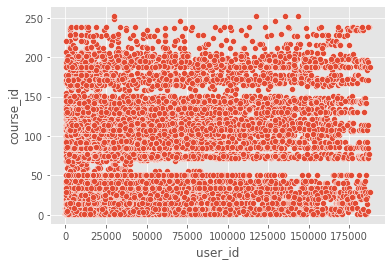

In [ ]:
sns.scatterplot(data = otus_user_course, x = 'user_id', y = 'course_id')


МОЖЕТ СДЕЛАТЬ КОЛЛАБОРАТИВНУЮ ФИЛЬТРАЦИЮ НА ОСНОВЕ БИНАРНОЙ КЛАССИФИКАЦИИ. ВЗЯЛ ИЛИ НЕ ВЗЯЛ ПОЛЬЗОВАТЕЛЬ КУРС??? Не оценки, а 0 и 1 по курсу для пользователей, тогда можно вогнать и surprise туда.

Кстати можно специально вносить новых пользователей, задавая им user_id и холодный старт, что-то подообное есть в гибридном подходе.

### Смотрю вебинар по коллаборативной фильтрации...

Вначале tf-idf. **Content - based**...  Content здесь взятые курсы... Надо выяснить, как работать с двухязычным title.

**Ассоциативные правила**. Пиво с подгузниками. Там как раз бинарная матрица.
Transaction ~ user_id, взятые курсы (номера, титлы, вектора этих курсов) - своего рода подгузники с пивом (товары).

### Парсинг сайтов

Библиотеки

In [ ]:
import requests      # Библиотека для отправки запросов
import numpy as np   # Библиотека для матриц, векторов и линала
import pandas as pd  # Библиотека для табличек 
import time          # Библиотека для времени

На следующем сайте находится разбивка по специализациям:

In [ ]:
page_link = 'https://otus.ru/categories/spec/'

Откроем данный сайт с помощью библиотеки request.

In [ ]:
response = requests.get(page_link)
response

<Response [200]>

Отклик 200, пляски с бубном отменяются. Сайт открылся.

Перенесём содержимое странички в переменную html.

In [ ]:
html = response.content

In [ ]:
html[:1000]

b'\n\n\n\n\n<!doctype html>\n<html lang="ru" class="no-js no-touch ">\n    <head>\n        <meta charset="utf-8">\n        <meta name="viewport" content="width=device-width,minimum-scale=1,initial-scale=1">\n        <meta http-equiv="X-UA-Compatible" content="IE=edge,chrome=1">\n        <meta name="yandex-verification" content="3b993f911b5af29e" />\n        \n\n        \n            <script type="text/javascript">\n                var html = document.getElementsByTagName(\'html\')[0];\n                html.className = html.className.replace(\'no-js\', \'\');\n\n                window.React = {};\n                window.metrics = [];\n                window.TEST_ENV = false;\n                window.isSuperuser = false;\n\n                \n            </script>\n\n            \n        \n\n        \n        \n\n\n    \n        \n            <link href="//api.jivosite.com" rel="preconnect"/>\n        \n\n        \n            <script type="text/javascript">\n                window.DEBUG_

In [ ]:
html[-1000:]

b's-sticky-banner sticky-banner_hidden">\r\n          <div class="sticky-banner__content">\r\n            <div class="sticky-banner__discount">\r\n              <div class="sticky-banner__discount-icon"></div>\r\n              <div class="sticky-banner__discount-text">\r\n                <div class="sticky-banner__discount-text_title">\xf0\x9f\x8e\x84 \xd0\x9d\xd0\xbe\xd0\xb2\xd0\xbe\xd0\xb3\xd0\xbe\xd0\xb4\xd0\xbd\xd1\x8f\xd1\x8f \xd1\x80\xd0\xb0\xd1\x81\xd0\xbf\xd1\x80\xd0\xbe\xd0\xb4\xd0\xb0\xd0\xb6\xd0\xb0!</div>\r\n                <div class="sticky-banner__discount-text_caption">\r\n              \xd0\x9c\xd0\xb0\xd0\xba\xd1\x81\xd0\xb8\xd0\xbc\xd0\xb0\xd0\xbb\xd1\x8c\xd0\xbd\xd0\xb0\xd1\x8f \xd1\x81\xd0\xba\xd0\xb8\xd0\xb4\xd0\xba\xd0\xb0 \xd0\xbd\xd0\xb0 \xd0\xba\xd1\x83\xd1\x80\xd1\x81\xd1\x8b \xd0\xb2 \xd0\xb4\xd0\xb5\xd0\xba\xd0\xb0\xd0\xb1\xd1\x80\xd0\xb5! \xd0\x9a\xd0\xbe\xd0\xbb\xd0\xb8\xd1\x87\xd0\xb5\xd1\x81\xd1\x82\xd0\xb2\xd0\xbe \xd0\xbc\xd0\xb5\xd1\x81\xd1\x82 \xd0\

In [ ]:
len(html)

301442

In [ ]:
type(html)

bytes

Красивый суп.

In [ ]:
from bs4 import BeautifulSoup

In [ ]:
soup = BeautifulSoup(html, 'html.parser') # В опции также можно указать lxml, 
                                         # если предварительно установить одноименный пакет

In [ ]:
print(soup.prettify()[:2000])

<!DOCTYPE doctype html>
<html class="no-js no-touch " lang="ru">
 <head>
  <meta charset="utf-8"/>
  <meta content="width=device-width,minimum-scale=1,initial-scale=1" name="viewport"/>
  <meta content="IE=edge,chrome=1" http-equiv="X-UA-Compatible"/>
  <meta content="3b993f911b5af29e" name="yandex-verification">
   <script type="text/javascript">
    var html = document.getElementsByTagName('html')[0];
                html.className = html.className.replace('no-js', '');

                window.React = {};
                window.metrics = [];
                window.TEST_ENV = false;
                window.isSuperuser = false;
   </script>
   <link href="//api.jivosite.com" rel="preconnect"/>
   <script type="text/javascript">
    window.DEBUG_COUNTERS = true;

                var yaParams = {
                    'course_title': 'b',
                    'ab': 'b',
                    'features': JSON.parse('{"month_overdraft": false, "new_course_page_slim": false, "new_lessons_page": t

In [ ]:
obj = soup.find('a', attrs = {'class':'photo'})
obj

header2-menu__subdropdown-item

Курсы меняются, добавляются новые, возможно остаются старые или исчезают. Нужно взять с сайта наименования курсов на определённый момент и порекомендовать к прохождению. Сравнить полученные курсы с предыдущей базой курсов. Будет дополнительная база курсов. !!! А что если у предлагаемого курса более сильная степень знаний, будем считать, что естественно уже брал данный человек подобный курс и более слабый курс точно модель в силу этого не порекомендует.

In [ ]:
soup.find_all('title')

[<title>Специализации OTUS - Онлайн-образование</title>]

In [ ]:
objs = soup.find_all('a', attrs = {'class':'header2-menu__subdropdown-item'})
objs

[<a class="header2-menu__subdropdown-item header2-menu__subdropdown-item_discount " href="/lessons/highloadarchitect/" title="Highload Architect">
                                             Highload Architect
                                             
                                                 <div class="header2-menu__subdropdown-discount">-20%</div>
 </a>,
 <a class="header2-menu__subdropdown-item header2-menu__subdropdown-item_discount " href="/lessons/javascript-basic/" title="JavaScript Developer. Basic">
                                             JavaScript Developer. Basic
                                             
                                                 <div class="header2-menu__subdropdown-discount">-20%</div>
 </a>,
 <a class="header2-menu__subdropdown-item header2-menu__subdropdown-item_discount " href="/lessons/microservice-architecture/" title="Microservice Architecture">
                                             Microservice Architecture
      

In [ ]:
len(objs)

166

In [ ]:
actual_courses = []
for obj in objs:
    actual_courses.append(obj.attrs['title'])

In [ ]:
len(actual_courses) ## Все ли курсы в этом листе уникальные??? По интуиции да. Проверить.

166

Сделаем, чтобы не было повторов, в случае их наличия.

In [ ]:
actual_courses = list(set(actual_courses))
len(actual_courses)

121

Существенное изменение.

In [ ]:
import random
random.choices(actual_courses, k=5)

['3D-моделирование игр с нуля',
 'Специализация Android-разработчик',
 'Machine Learning. Advanced',
 'iOS Developer. Professional',
 'iOS Developer. Basic']

Сравним список actual_courses и course_info.title



In [ ]:
courses_almosttitle = course_info.title.tolist()
len(courses_almosttitle) ## courses_almost мы делали в id
## Тоже проверить на уникальность перед сравнением с actual_courses

239

Необходимы уникальные названия курсов, которые брали пользователи, а пользователи могли брать похожие курсы, поэтому нужен следующий код.

In [ ]:
courses_almosttitle = list(set(courses_almosttitle))
len(courses_almosttitle)

237

Теперь мы точно уверены, что у нас нет повторов в названии курсов.

In [ ]:
random.choices(courses_almosttitle, k=5)

['Разработчик BigData',
 'Экcпресс-курс «ELK»',
 'Embedded-разработчик',
 'C# ASP.NET Core разработчик',
 'Network engineer']

Сравним на пересечение actual_courses и courses_almosttitle

In [ ]:
 ## actual_courses и courses_almosttitle
 print(sorted(list(set(actual_courses).intersection(set(courses_almosttitle)))))

['Administrator Linux. Advanced', 'Administrator Linux. Professional', 'Administrator Linux.Basic', 'Agile Project Manager', 'Android Developer. Basic', 'Android Developer. Professional', 'C# ASP.NET Core разработчик', 'C# Developer. Professional', 'C++ Developer. Professional', 'Cloud Solution Architecture', 'Data Engineer', 'Data Warehouse Analyst', 'DevOps практики и инструменты', 'Enterprise Architect', 'Flutter Mobile Developer', 'Framework Laravel', 'Game QA Engineer', 'Golang Developer. Professional', 'Highload Architect', 'IT-Recruiter', 'Java Developer. Basic', 'Java Developer. Professional', 'JavaScript Developer. Basic', 'JavaScript Developer. Professional', 'JavaScript QA Engineer', 'Kotlin Backend Developer', 'MS SQL Server Developer', 'Machine Learning. Advanced', 'Machine Learning. Basic', 'Machine Learning. Professional', 'Microservice Architecture', 'Network engineer', 'Network engineer. Basic', 'NoSQL', 'Node.js Developer', 'PostgreSQL', 'Product Manager IT-проектов',

In [ ]:
common_courses = sorted(list(set(actual_courses).intersection(set(courses_almosttitle))))
len(common_courses)

81

Интересное наблюдение! Есть несколько похожих, но их немного. Это связующие курсы между теми что были, и что есть.
Резюме:

In [ ]:
len(courses_almosttitle), len(actual_courses), len(common_courses)

(237, 121, 81)

In [ ]:
# random.choices(courses_allmost, k=5)

Отдельно сформируем общую переменную, где будут отражены все специальности по одному разу.

In [ ]:
all_courses = sorted(list(set(actual_courses + courses_almosttitle)))
len(all_courses)

277

In [ ]:
all_courses = sorted(list(set(actual_courses).union(set(courses_almosttitle))))
len(all_courses)

277

Проверим, что всё верно.

In [ ]:
len(courses_almosttitle) - len(common_courses) + len(actual_courses) == len(all_courses)

True

### ИГРА В ЭМБЕДДИНГ МНОГОЯЗЫКОВОЙ, СНАЧАЛА НА ПРИМЕРЕ, ПОТОМ БОЕВОЙ РЕЖИМ

In [ ]:
!pip install transformers

     |████████████████████████████████| 3.4 MB 4.3 MB/s 
     |████████████████████████████████| 895 kB 59.4 MB/s 
     |████████████████████████████████| 596 kB 45.8 MB/s 
     |████████████████████████████████| 3.3 MB 28.0 MB/s 
     |████████████████████████████████| 61 kB 464 kB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
import torch
from transformers import AutoTokenizer, AutoModel
tokenizer = AutoTokenizer.from_pretrained("cointegrated/LaBSE-en-ru")
model = AutoModel.from_pretrained("cointegrated/LaBSE-en-ru")
sentences = ["Hello World", "Привет Мир"]
encoded_input = tokenizer(sentences, padding=True, truncation=True, max_length=64, return_tensors='pt')
with torch.no_grad():
    model_output = model(**encoded_input)
embeddings = model_output.pooler_output
embeddings = torch.nn.functional.normalize(embeddings)
print(embeddings)

Downloading:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/806 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/509k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/492M [00:00<?, ?B/s]

Some weights of the model checkpoint at cointegrated/LaBSE-en-ru were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


tensor([[-0.0714, -0.0772, -0.0305,  ...,  0.0136, -0.0402, -0.0245],
        [-0.0644, -0.0687, -0.0521,  ...,  0.0139, -0.0362, -0.0213]])


In [ ]:
embeddings.shape

torch.Size([2, 768])

In [ ]:
import torch
from transformers import AutoTokenizer, AutoModel
tokenizer = AutoTokenizer.from_pretrained("cointegrated/LaBSE-en-ru")
model = AutoModel.from_pretrained("cointegrated/LaBSE-en-ru")
sentences = ["Hello Word", "Привет Мр", "Raz D", "Раз Д"]
encoded_input = tokenizer(sentences, padding=True, truncation=True, max_length=64, return_tensors='pt')
with torch.no_grad():
    model_output = model(**encoded_input)
embeddings = model_output.pooler_output
embeddings = torch.nn.functional.normalize(embeddings)
print(embeddings)

Some weights of the model checkpoint at cointegrated/LaBSE-en-ru were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


tensor([[-0.0350, -0.0613, -0.0206,  ...,  0.0467, -0.0477, -0.0093],
        [-0.0157, -0.0543, -0.0264,  ..., -0.0198, -0.0170,  0.0006],
        [-0.0526, -0.0535, -0.0092,  ..., -0.0480,  0.0163, -0.0267],
        [-0.0506, -0.0540,  0.0107,  ..., -0.0316, -0.0611, -0.0348]])


In [ ]:
embeddings.shape

torch.Size([4, 768])

По-хорошему, нам нужны embeddings наших title.

У нас есть три вида курсов, скачанные с Otus, предложенные в задачи, и их пересечение, то есть то, что есть там и здесь, переменные таковы:  
actual_courses и courses_almosttitle и их пересечение common_courses  

Не понятно, как сравнивать embeddingы. Стоит ли здесь три разных группы векторов-эмбеддингов из этих всех трёх векторов, embeddings_ac, embeddings_ca, embeddings_cc и уже сравнивать их в пространстве общей размерности???

In [ ]:
import torch
from transformers import AutoTokenizer, AutoModel
tokenizer = AutoTokenizer.from_pretrained("cointegrated/LaBSE-en-ru")
model = AutoModel.from_pretrained("cointegrated/LaBSE-en-ru")

#sentences_ac = actual_courses
#sentences_ca = courses_almosttitle ## added +
#sentences_cc = common_courses      ## added ++ 

encoded_input = tokenizer(sentences, padding=True, truncation=True, max_length=64, return_tensors='pt')
with torch.no_grad():
    model_output = model(**encoded_input)
embeddings = model_output.pooler_output
embeddings = torch.nn.functional.normalize(embeddings)
print(embeddings)

Some weights of the model checkpoint at cointegrated/LaBSE-en-ru were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


tensor([[-0.0350, -0.0613, -0.0206,  ...,  0.0467, -0.0477, -0.0093],
        [-0.0157, -0.0543, -0.0264,  ..., -0.0198, -0.0170,  0.0006],
        [-0.0526, -0.0535, -0.0092,  ..., -0.0480,  0.0163, -0.0267],
        [-0.0506, -0.0540,  0.0107,  ..., -0.0316, -0.0611, -0.0348]])


Поскольку у нас есть несколько (три) варианта корпуса текстов, создадим отдельно фукнцию по определению эмбеддингов.  
**Функция LaBSE_embedding:**

In [ ]:
def LaBSE_embedding (sentences):    
    encoded_input = tokenizer(sentences, padding=True, truncation=True, max_length=64, return_tensors='pt')
    with torch.no_grad():
        model_output = model(**encoded_input)
    embeddings = model_output.pooler_output
    embeddings = torch.nn.functional.normalize(embeddings)
    print(embeddings)
    return embeddings

In [ ]:
embeddings_ac = LaBSE_embedding(actual_courses)

tensor([[-0.0106,  0.0014, -0.0216,  ..., -0.0097,  0.0271,  0.0418],
        [-0.0333, -0.0568, -0.0465,  ..., -0.0455, -0.0597, -0.0485],
        [ 0.0557, -0.0770, -0.0560,  ..., -0.0489, -0.0337, -0.0267],
        ...,
        [-0.0332, -0.0746, -0.0361,  ..., -0.0283,  0.0241,  0.0343],
        [ 0.0241, -0.0525, -0.0568,  ..., -0.0175,  0.0408, -0.0340],
        [ 0.0113, -0.0608,  0.0167,  ..., -0.0202, -0.0058, -0.0589]])


In [ ]:
embeddings_ca = LaBSE_embedding(courses_almosttitle)

tensor([[-0.0566, -0.0433, -0.0226,  ..., -0.0567, -0.0136,  0.0425],
        [-0.0103, -0.0551, -0.0686,  ..., -0.0195, -0.0131, -0.0290],
        [ 0.0127, -0.0247,  0.0040,  ..., -0.0479,  0.0170, -0.0541],
        ...,
        [ 0.0480, -0.0497,  0.0024,  ..., -0.0164,  0.0295, -0.0444],
        [ 0.0217, -0.0597, -0.0129,  ..., -0.0286, -0.0463, -0.0681],
        [ 0.0113, -0.0608,  0.0167,  ..., -0.0202, -0.0058, -0.0589]])


In [ ]:
embeddings_cc = LaBSE_embedding(common_courses)

tensor([[ 0.0190, -0.0230,  0.0016,  ..., -0.0282, -0.0113, -0.0028],
        [ 0.0226, -0.0374,  0.0030,  ..., -0.0406,  0.0125,  0.0082],
        [ 0.0072, -0.0512,  0.0151,  ..., -0.0374, -0.0028,  0.0407],
        ...,
        [ 0.0635, -0.0768, -0.0269,  ..., -0.0526, -0.0318, -0.0126],
        [ 0.0294, -0.0305, -0.0448,  ..., -0.0271,  0.0038, -0.0162],
        [ 0.0585, -0.0434, -0.0300,  ..., -0.0524, -0.0489, -0.0269]])


In [ ]:
embeddings_allc = LaBSE_embedding(all_courses)

tensor([[ 0.0157, -0.0397,  0.0298,  ..., -0.0717, -0.0093, -0.0392],
        [-0.0218, -0.0831, -0.0070,  ...,  0.0292, -0.0460, -0.0422],
        [ 0.0073, -0.0577, -0.0285,  ..., -0.0399, -0.0423, -0.0288],
        ...,
        [ 0.0294, -0.0305, -0.0448,  ..., -0.0271,  0.0038, -0.0162],
        [-0.0109, -0.0166, -0.0424,  ..., -0.0128, -0.0552,  0.0679],
        [ 0.0585, -0.0434, -0.0300,  ..., -0.0524, -0.0489, -0.0269]])


In [ ]:
embeddings_ac.shape

torch.Size([121, 768])

In [ ]:
embeddings_ca.shape

torch.Size([237, 768])

In [ ]:
embeddings_cc.shape

torch.Size([81, 768])

Мы будем работать со следующим эмбеддингом, обогащённым новыми данными с сайта.

In [ ]:
embeddings_allc.shape

torch.Size([277, 768])

In [ ]:
id2course = {}
for i, row in course_info.iterrows():
    id2course[i] = row.title
    
print([id2course[i] for i in val_preds[0]])

['Backend-разработчик на PHP', 'Разработчик Java\xa0(очно в МАИ)', 'Разработчик Ruby']


In [ ]:
otus_user_course.shape

(14675, 2)

In [ ]:
X.shape

(14675, 2)

In [ ]:
id2course

{0: 'Java Developer. Professional',
 1: 'Разработчик Android (deprecated)',
 2: 'Python Developer. Professional',
 3: 'Разработчик Ruby',
 4: 'C++ Developer. Professional',
 5: 'Цифровая подпись в ИБ',
 6: 'DevOps практики и инструменты',
 7: 'Backend-разработчик на PHP',
 8: 'Разработчик full-stack на Python',
 9: 'Руководитель разработки',
 10: 'Курс для преподавателей',
 11: 'Руководитель ИТ-подразделения',
 12: 'Онлайн-преподаватель',
 13: 'Разработчик BigData',
 14: 'Administrator Linux. Professional',
 15: 'Разработчик Java\xa0(очно в МАИ)',
 16: 'SEO оптимизатор',
 17: 'Разработчик Java  Enterprise',
 18: 'Digital маркетолог',
 19: 'JavaScript Developer. Professional',
 20: 'Разработчик Android',
 21: 'Проектирование UX/UI',
 22: 'Java QA Engineer',
 23: 'C# Developer. Professional',
 24: 'Web-разработчик на Python',
 25: 'Графический дизайнер',
 26: 'Product owner',
 27: 'IT-Recruiter',
 28: 'iOS Developer. Professional',
 29: 'Scrum-мастер',
 30: 'Аналитик бизнес-процессов',
 

In [ ]:
X

,user_id,course_id
0,4,1
1,81,1
2,83,1
3,120,1
4,123,1
...,...,...
14970,117282,252
14971,186547,238
14972,186835,238
14973,128483,23


Создадим датафрейм, где рядом будут и номер Юзера и номер курса и название курса, по названиям курса будем проводить косинусную близость с помощью полученных эмбеддингов.  
Назовём датафрейм **Xadd**.

In [ ]:
Xadd = X.merge(course_info, left_on='course_id', right_on='id', how = 'inner')

In [ ]:
Xadd.shape

(14675, 4)

In [ ]:
len(Xadd)

14675

In [ ]:
Xadd

,user_id,course_id,id,title
0,4,1,1,Java Developer. Professional
1,81,1,1,Java Developer. Professional
2,83,1,1,Java Developer. Professional
3,120,1,1,Java Developer. Professional
4,123,1,1,Java Developer. Professional
...,...,...,...,...
14670,135376,252,252,Специализация Machine Learning
14671,143563,252,252,Специализация Machine Learning
14672,117282,252,252,Специализация Machine Learning
14673,103337,220,220,Enterprise Architect


In [ ]:
id2course[2]

'Python Developer. Professional'

Косинунсная близость.

In [ ]:
from sklearn.metrics.pairwise import linear_kernel, cosine_similarity
#cosine_similarities = cosine_similarity(embeddings_allc)
cosine_similarities = cosine_similarity(embeddings_ca)

ca это courses_almosttitle

In [ ]:
courses_almosttitle

['Deep Learning. Basic',
 'Разработчик Java\xa0(очно в МАИ)',
 'SMM-специалист',
 'Безопасность баз данных',
 'Нагрузочное тестирование',
 'Data Scientist',
 'Продвинутый тестировщик тестов',
 'Специализация Machine Learning (Dark)',
 'Подготовка к сертификации Oracle Java Programmer (OCAJP)',
 'C++ Developer. Professional',
 'QA-специалист',
 'Безопасность информационных систем',
 'Супер-практикум по использованию и настройке GIT',
 'Супер - интенсив по паттернам проектирования',
 'TeachTalkBar 21+',
 'BPMN: Моделирование бизнес-процессов',
 'Защита персональных данных в корпоративных системах',
 'Administrator Linux.Basic',
 'Backend-разработчик на PHP',
 'NOSQL',
 'Специализация Java и Базы данных',
 'Пентест. Базовый курс',
 'Framework Laravel',
 'CI/CD',
 'Внедрение и работа в DevSecOps',
 'Алгоритмы и структуры данных',
 'Инфраструктурная платформа на основе Kubernetes',
 'ML-СКБ',
 'Анализ данных и машинное обучение в MATLAB',
 'Machine Learning. Basic',
 'Кросс-команда',
 'Мате

In [ ]:
embeddings_ca.shape #вначале попробуем на первоначальном списке курсов обучить модель

torch.Size([237, 768])

In [ ]:
cosine_similarities.shape

(237, 237)

In [ ]:
cosine_similarities

array([[1.0000001 , 0.20511071, 0.15526554, ..., 0.19333452, 0.27173197,
        0.05508123],
       [0.20511071, 0.9999999 , 0.39506796, ..., 0.25403893, 0.24663982,
        0.43195707],
       [0.15526554, 0.39506796, 0.9999999 , ..., 0.41662943, 0.29169005,
        0.5030395 ],
       ...,
       [0.19333452, 0.25403893, 0.41662943, ..., 1.        , 0.3939144 ,
        0.29855734],
       [0.27173197, 0.24663982, 0.29169005, ..., 0.3939144 , 1.0000002 ,
        0.5021602 ],
       [0.05508123, 0.43195707, 0.5030395 , ..., 0.29855734, 0.5021602 ,
        0.9999998 ]], dtype=float32)

In [ ]:
len(cosine_similarities)

237

In [ ]:
similarities = {}
for i in range(len(cosine_similarities)):
    # сортировка по схожести и запись индексов
    similar_indices = cosine_similarities[i].argsort()[:-50:-1] 
    # 10 самых похожих курсов # 50
    #similarities[item_lookup['StockCode'].iloc[i]] = [(cosine_similarities[i][x], item_lookup.iloc[x]['Description'], item_lookup.iloc[x]['StockCode']) for x in similar_indices][1:]
    similarities[Xadd['user_id'].iloc[i]] = [(cosine_similarities[i][x], Xadd.iloc[x]['title'], Xadd.iloc[x]['user_id']) for x in similar_indices][1:]

In [ ]:
similar_indices

array([236,  48,  53,  69, 158,  75, 106, 140, 130,  93, 217, 105,  74,
       136, 168, 212,  81,  96,  49, 131,  46, 231, 201, 160, 108,  40,
       155,  78,   2, 235,  83,  89, 118, 202, 128, 185,  57, 186, 221,
        32, 121, 101,  10,  60,  64, 170, 157, 123, 228])

In [ ]:
courses_almosttitle[236]

'Product Manager IT-проектов'

In [ ]:
courses_almosttitle[82]

'Разработчик full-stack на Python'

In [ ]:
courses_almosttitle[159]

'Python Developer. Professional'

In [ ]:
courses_almosttitle[0]

'Deep Learning. Basic'

In [ ]:
similar_indices_Xadd = []
for i in range(len(cosine_similarities)):
    # сортировка по схожести и запись индексов
    similar_indices_Xadd.append(cosine_similarities[i].argsort()[:-10:-1])

In [ ]:
len(similar_indices_Xadd), len(similar_indices_Xadd[10])

(237, 9)

In [ ]:
#id2course = {}
#for i, row in course_info.iterrows():
#    id2course[i] = row.title

In [ ]:
len(courses_almosttitle)

237

**title2number**

In [ ]:
title2number = {}
for i, course in enumerate(courses_almosttitle):
  title2number[course] = i

Создали вспомогательный словарь, который преобразует название курса в порядковый номер в списке courses_almosttitle.

In [ ]:
title2number

{'AWS for Data Science': 195,
 'AWS для разработчиков': 123,
 'Administrator Linux. Advanced': 173,
 'Administrator Linux. Professional': 117,
 'Administrator Linux.Basic': 17,
 'Advanced Fullstack JavaScript developer': 72,
 'Agile Delivery Manager': 121,
 'Agile Project Manager': 158,
 'Android Developer. Basic': 38,
 'Android Developer. Professional': 50,
 'BPMN: Моделирование бизнес-процессов': 15,
 'Backend-разработчик на PHP': 18,
 'Big Data для менеджеров': 96,
 'C# ASP.NET Core разработчик': 185,
 'C# Developer. Professional': 66,
 'C# Базовый курс': 138,
 'C++ Developer. Professional': 9,
 'CI/CD': 23,
 'CRM-менеджер': 75,
 'CTF по ИБ': 194,
 'Cloud Solution Architecture': 166,
 'Customer Development. Онлайн-практикум': 95,
 'Data Engineer': 162,
 'Data Engineer для Райффайзенбанка': 171,
 'Data Scientist': 5,
 'Data Warehouse Analyst': 94,
 'Deep Learning. Basic': 0,
 'DevOps для ВТБ': 180,
 'DevOps практики и инструменты': 84,
 'DevOps&Linux': 219,
 'Devops для Почты России'

In [ ]:
similarities_Xadd = {}
for i in range(len(cosine_similarities)):
    # сортировка по схожести и запись индексов
    similar_indices = cosine_similarities[i].argsort()[:-50:-1] 
    # 10 самых похожих курсов # 50
    #similarities[item_lookup['StockCode'].iloc[i]] = [(cosine_similarities[i][x], item_lookup.iloc[x]['Description'], item_lookup.iloc[x]['StockCode']) for x in similar_indices][1:]
    similarities[Xadd['user_id'].iloc[i]] = [(cosine_similarities[i][x], Xadd.iloc[x]['title'], Xadd.iloc[x]['user_id']) for x in similar_indices][1:]

In [ ]:
# Здесь расположены индексы косинусной близости к конкретному курсу (по индексу)
# similar_indices_Xadd 
# Здесь можно выцепить по названию нужный индекс
# title2number

Задачка такая, пробегаем по датафрейм Xadd, берём название из title и предлагаем ему нужную рекомендашку согласно title2number и similar_indices_Xadd

In [ ]:
Xadd.columns

Index(['user_id', 'course_id', 'id', 'title'], dtype='object')

Сделаем рекомендацию, для юзера 10000, он выбрал title такой:

In [ ]:
Xadd.iloc[10000].user_id, Xadd.iloc[10000].course_id, Xadd.iloc[10000].title

(119130, 110, 'Team Lead')

Мы создали свой список курсов courses_almosttitle, в котором нумерация отличается:  

In [ ]:
title2number[Xadd.iloc[10000].title]

39

Согласно нашему списку и полученной матрицы косинусной близости, мы для нашего курса можем найти похожие, интересные курсы:

In [ ]:
cbrrecindex = similar_indices_Xadd[title2number[Xadd.iloc[10000].title]]
cbrrecindex

array([ 39,  30,  93,  69,  48, 139,  32, 201, 202])

Вспомогательная функция **get_key**, для получения ключа по значению, поможет найти близкие курсы, которые стоит порекомендовать.  

In [ ]:
def get_key(d, value):
    for k, v in d.items():
        if v == value:
            return k

Выведем список рекомендованных курсов:  

In [ ]:
for i in cbrrecindex:
    print(get_key(title2number, i))

Team Lead
Кросс-команда
Руководитель ИБ
Руководитель разработки
Руководитель ИТ-подразделения
QA Lead
Руководитель онлайн-курсов
Трафик-менеджер
Test-менеджмент


Мы видим, что рекомендованный список очень коррелирует с тем, что было заложено на вход. Для руководителя предлагается пройти курсы, тоже связанные с руководство и лидерством, работе в команде на главных позициях.  

### Рабочий дополнительный материал.  

In [ ]:
for k in cbrrecindex:
     print(courses_allmost[k])

45
31
103
78
56
149
33
215
217


In [ ]:
similarities

{4: [(0.728283, 'Java Developer. Professional', 659),
  (0.645911, 'Java Developer. Professional', 6883),
  (0.5844854, 'Java Developer. Professional', 6927),
  (0.5186218, 'Java Developer. Professional', 361),
  (0.49079108, 'Java Developer. Professional', 616),
  (0.48216867, 'Java Developer. Professional', 171),
  (0.46848553, 'Java Developer. Professional', 812),
  (0.44761634, 'Java Developer. Professional', 2011),
  (0.44759035, 'Java Developer. Professional', 11036),
  (0.44512686, 'Java Developer. Professional', 11130),
  (0.43385908, 'Java Developer. Professional', 4573),
  (0.4318173, 'Java Developer. Professional', 4812),
  (0.42598662, 'Java Developer. Professional', 1804),
  (0.39284784, 'Java Developer. Professional', 566),
  (0.3906677, 'Java Developer. Professional', 513),
  (0.38770947, 'Java Developer. Professional', 5005),
  (0.37860307, 'Java Developer. Professional', 1737),
  (0.37651062, 'Java Developer. Professional', 6626),
  (0.3652579, 'Java Developer. Profess

In [ ]:
class ContentBasedRecommender:
    def __init__(self, matrix):
        self.matrix_similar = matrix

    def _print_message(self, item, recom_item):
        rec_items = len(recom_item)
        
        print(f'The {rec_items} recommended items are:')
        for i in range(rec_items):
            print(f"Number {i+1}:")
            print(f"{recom_item[i][1]} with {round(recom_item[i][0], 3)} similarity score") 
            print("--------------------")
        
    def recommend(self, recommendation, verbose = True):
        # Выбрать песню для поиска рекомендаций
        item = recommendation['item']
        # Выбрать число песен для рекомендаций
        number_items = recommendation['item_number']
        # Выбрать число песен, наиболее похожее из матрицы
        recom_item = self.matrix_similar[item][:number_items]
        # распечатать
        if verbose:
            self._print_message(item=item, recom_item=recom_item)
        return recom_item

In [ ]:
recommendations = ContentBasedRecommender(similarities)

Теперь выберем курс и сделаем предикт.

In [ ]:
#idx = 10

#recommendation = {
#    "item": item_lookup['StockCode'].iloc[idx],
#    "item_number": 5
#}
#print('Recommendations for ',item_lookup['StockCode'].iloc[idx], item_lookup['Description'].iloc[idx],':\n\n')
#recom_item = recommedations.recommend(recommendation)

In [ ]:
Xadd.iloc[1000]

user_id                               21797
course_id                                 3
id                                        3
title        Python Developer. Professional
Name: 1000, dtype: object

In [ ]:
similarities

{4: [(0.79325986, 'Java Developer. Professional', 1762),
  (0.76955265, 'Java Developer. Professional', 344),
  (0.7595258, 'Java Developer. Professional', 10560),
  (0.74083865, 'Java Developer. Professional', 13554),
  (0.7180974, 'Java Developer. Professional', 246),
  (0.6869135, 'Java Developer. Professional', 5006),
  (0.6583487, 'Java Developer. Professional', 1866),
  (0.65298504, 'Java Developer. Professional', 307),
  (0.6106615, 'Java Developer. Professional', 8369),
  (0.60141885, 'Java Developer. Professional', 81),
  (0.5972296, 'Java Developer. Professional', 7339),
  (0.5960991, 'Java Developer. Professional', 549),
  (0.5929457, 'Java Developer. Professional', 4943),
  (0.58849293, 'Java Developer. Professional', 11130),
  (0.58214766, 'Java Developer. Professional', 7067),
  (0.5817538, 'Java Developer. Professional', 4797),
  (0.58146244, 'Java Developer. Professional', 1466),
  (0.577138, 'Java Developer. Professional', 4314),
  (0.562421, 'Java Developer. Professio

In [ ]:
idx = 500

recommendation = {
    "item": Xadd['user_id'].iloc[idx],
    "item_number": 10
}
print('Recommendations for ', Xadd['user_id'].iloc[idx], Xadd['title'].iloc[idx],':\n\n')
recom_item = recommendations.recommend(recommendation)

In [ ]:
customer = 536366
cur_customer = retail_data[retail_data.InvoiceNo == customer].copy().sort_values('InvoiceDate')
cur_customer.head()

In [ ]:
recommendation = {
    "item": str(cur_customer.iloc[-1].StockCode),
    "item_number": 5
}
print('Recommendations for ',cur_customer.iloc[-1].StockCode, cur_customer.iloc[-1]['Description'].lower(),'\n\n')
recom_item = recommedations.recommend(recommendation)

In [ ]:
Xadd.sample(5)

,user_id,course_id,id,title
8462,68213,77,77,Reverse-Engineering. Basic
8383,39405,77,77,Reverse-Engineering. Basic
1790,18569,7,7,DevOps практики и инструменты
6746,7673,32,32,Нейронные сети на Python
8298,17896,75,75,Network engineer


In [ ]:
courses_Xadd = Xadd.title.tolist()

In [ ]:
embeddings_cXadd = LaBSE_embedding(courses_Xadd)

In [ ]:
from sklearn.metrics.pairwise import linear_kernel, cosine_similarity
#cosine_similarities = cosine_similarity(embeddings_allc)
cosine_similarities = cosine_similarity(embeddings_cXadd)